# Embedding Evaluation Using BERT

In [1]:
# Install required libraries
!pip install transformers scikit-learn matplotlib seaborn numpy scipy requests

# Clone SentEval for datasets
!git clone https://github.com/facebookresearch/SentEval.git

# Download benchmark datasets from SentEval
%cd SentEval/data/downstream
!bash get_transfer_data.bash
%cd ../../../


Cloning into 'SentEval'...
remote: Enumerating objects: 691, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 691 (delta 293), reused 277 (delta 277), pack-reused 296 (from 1)
Receiving objects: 100% (691/691), 33.23 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (452/452), done.
/content/SentEval/data/downstream
Cloning Moses github repository (for tokenization scripts)...
Cloning into 'mosesdecoder'...
remote: Enumerating objects: 148459, done.
remote: Counting objects: 100% (887/887), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 148459 (delta 565), reused 797 (delta 517), pack-reused 147572 (from 1)
Receiving objects: 100% (148459/148459), 129.99 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (114591/114591), done.
mkdir: cannot create directory ‘.’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload  

## Load BERT Model and Generate Embeddings

In [2]:
# Import required libraries
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load pretrained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # Set to evaluation mode

# Function to generate embeddings
def generate_embeddings_in_batches(sentences, batch_size=32, layer_combination='CLS'):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)

        with torch.no_grad():
            outputs = model(**inputs)

        # Embedding based on specified layer combination
        if layer_combination == 'CLS':
            # Use CLS token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        elif layer_combination == 'mean_pooling':
            # Mean pooling of token embeddings
            attention_mask = inputs['attention_mask']
            token_embeddings = outputs.last_hidden_state
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
            sum_mask = torch.clamp(attention_mask.sum(1).unsqueeze(-1), min=1e-9)
            batch_embeddings = sum_embeddings / sum_mask
        else:
            raise ValueError("Invalid layer_combination. Use 'CLS' or 'mean_pooling'.")

        embeddings.append(batch_embeddings.cpu().numpy())

    return np.vstack(embeddings)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [3]:
# Example
sample_sentences = ["I love this movie!", "This film was terrible."]
embeddings = generate_embeddings_in_batches(sample_sentences, batch_size=32, layer_combination='CLS')
print("Generated Embeddings Shape:", embeddings.shape)

Generated Embeddings Shape: (2, 768)


## Classification Evaluation on MR Dataset

In [4]:
# Load MR dataset from SentEval
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load MR dataset
dataset_path = "./SentEval/data/downstream/MR"
with open(os.path.join(dataset_path, "rt-polarity.pos"), "r") as f_pos:
    positive_samples = [line.strip() for line in f_pos.readlines()]
with open(os.path.join(dataset_path, "rt-polarity.neg"), "r") as f_neg:
    negative_samples = [line.strip() for line in f_neg.readlines()]


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1071
           1       0.81      0.79      0.80      1062

    accuracy                           0.81      2133
   macro avg       0.81      0.81      0.81      2133
weighted avg       0.81      0.81      0.81      2133



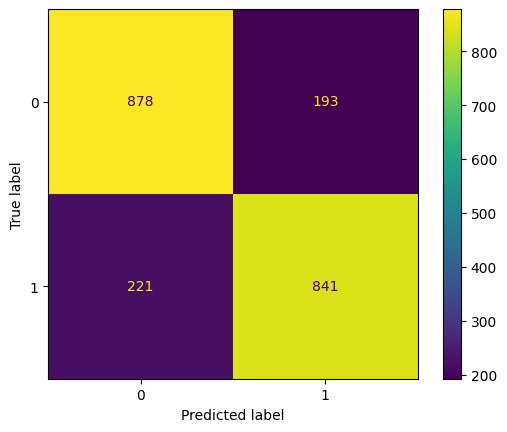

In [5]:
sentences = positive_samples + negative_samples
labels = [1] * len(positive_samples) + [0] * len(negative_samples)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Generate embeddings for train and test sets in batches
X_train_embeddings = generate_embeddings_in_batches(X_train, batch_size=32, layer_combination='CLS')
X_test_embeddings = generate_embeddings_in_batches(X_test, batch_size=32, layer_combination='CLS')

# Train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, solver='liblinear')
clf.fit(X_train_embeddings, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_embeddings)
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## STS Evaluation

In [6]:
import requests

def load_sts_dataset(url, columns=(0, 1, 2), delimiter="\t", skip_header=True):
    """
    Load and preprocess an STS dataset.

    :param url: Dataset URL
    :param columns: Tuple specifying the columns for word1, word2, and similarity score
    :param delimiter: Delimiter for splitting dataset rows
    :param skip_header: Whether to skip the header row
    :return: Tuple of word pairs and similarity scores
    """
    response = requests.get(url)
    lines = response.text.splitlines()
    if skip_header:
        lines = lines[1:]

    word_pairs, gold_scores = [], []
    for line in lines:
        parts = line.split(delimiter)
        if len(parts) > max(columns):
            word_pairs.append((parts[columns[0]], parts[columns[1]]))
            gold_scores.append(float(parts[columns[2]]))

    return word_pairs, gold_scores


In [7]:
from scipy.stats import spearmanr

def evaluate_sts(word_pairs, gold_scores, layer_combination="CLS", batch_size=32):
    """
    Compute cosine similarity and evaluate using Spearman correlation.

    :param word_pairs: List of word pairs
    :param gold_scores: List of gold standard similarity scores
    :param layer_combination: "CLS" or "mean_pooling"
    :param batch_size: Batch size for processing
    :return: Spearman correlation score
    """
    sentences = [word for pair in word_pairs for word in pair]
    embeddings = generate_embeddings_in_batches(sentences, batch_size=batch_size, layer_combination=layer_combination)

    similarities = []
    for i in range(0, len(embeddings), 2):
        word1_emb, word2_emb = embeddings[i], embeddings[i + 1]
        similarity = np.dot(word1_emb, word2_emb) / (np.linalg.norm(word1_emb) * np.linalg.norm(word2_emb))
        similarities.append(similarity)

    return spearmanr(similarities, gold_scores).correlation


In [9]:
# Dataset URLs
datasets = {
    "WS353-Sim": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/WS353-Sim.txt",
    "SimLex-999": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/SimLex999.txt",
    "SimVerb-3500": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/SimVerb-3500.txt"
}

# Load datasets
ws353_pairs, ws353_scores = load_sts_dataset(datasets["WS353-Sim"], columns=(0, 1, 2), delimiter="\t", skip_header=False)
simlex_pairs, simlex_scores = load_sts_dataset(datasets["SimLex-999"], columns=(0, 1, 2), delimiter="\t", skip_header=True)
simverb_pairs, simverb_scores = load_sts_dataset(datasets["SimVerb-3500"], columns=(0, 1, 3), delimiter="\t", skip_header=True)

# Evaluate
ws353_corr = evaluate_sts(ws353_pairs, ws353_scores, layer_combination="CLS")
simlex_corr = evaluate_sts(simlex_pairs, simlex_scores, layer_combination="CLS")
simverb_corr = evaluate_sts(simverb_pairs, simverb_scores, layer_combination="CLS")

print(f"WS353-Sim Spearman Correlation: {ws353_corr}")
print(f"SimLex-999 Spearman Correlation: {simlex_corr}")
print(f"SimVerb-3500 Spearman Correlation: {simverb_corr}")


WS353-Sim Spearman Correlation: 0.23062588509359758
SimLex-999 Spearman Correlation: 0.07161648626084677
SimVerb-3500 Spearman Correlation: 0.013135778636316316
